# Machine Learning Engineer Nanodegree
## Nanodegree Capstone
## Project: Lending Club Factors of Repayment

In [1]:
#Importing libraries used throughout the notebook
#Other libraries and functions are imported below as needed

import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt 
%matplotlib inline

#reading in the data from the csv file
data = pd.read_csv('LoanStats3aa.csv')

#Breif preview of the dataframe
display(data.head(n=6))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
#int_rate and revol_util is stores as text not a number. 

#Print an example of the columns in question to confirm they are of type 'str'
print(type(data['int_rate'][0]), data['int_rate'][0])
print(type(data['revol_util'][0]), data['revol_util'][0])

#Strips the '%' from the text so it can be converted to numeric values
data.int_rate = data.int_rate.str.replace('%','')
data.revol_util = data.revol_util.str.replace('%','')

#Uses pandas function to conver the string of to a numeric value. 
#I've avoided dividing converting to decimal format becuse preprocessing will normalize below 
data.int_rate = pd.to_numeric(data.int_rate, errors='coerce')
data.revol_util = pd.to_numeric(data.revol_util, errors='coerce')

#Print out examples from above, no longer 'str' numeric values are as expected 
print(type(data['int_rate'][0]), data['int_rate'][0])
print(type(data['revol_util'][0]), data['revol_util'][0])


<class 'str'> 10.65%
<class 'str'> 83.70%
<class 'numpy.float64'> 10.65
<class 'numpy.float64'> 83.7


There are 145 features in the dataset. Not all of these are available at the time of investment. The invest_info list contains all the features avaiable at the time of investment.

The target variable is loan_status.  This is stored as eithr "Fully Paid" or "Charged off".  The paidoff variable is True when the loan_status is Fully Paid and False when it is Charged Off.

In [3]:
#List of features observable at the time of investment
invest_info = ['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_title','emp_length','home_ownership','annual_inc','verification_status','purpose','zip_code','addr_state','dti','delinq_2yrs','earliest_cr_line','inq_last_6mths','mths_since_last_delinq','mths_since_last_record','open_acc','pub_rec','revol_bal','revol_util','total_acc','initial_list_status','collections_12_mths_ex_med','mths_since_last_major_derog','acc_now_delinq','delinq_amnt']

#sets up raw features to be just the observable features
features_raw = data[invest_info] 

#Print the length of raw features and invest_info to make sure all features are captured
print("The number of features avaiable at investment: {}".format(len(invest_info)))
print("The number of features in the features_raw: {}".format(len(features_raw.columns)))

#Establishes the target variable with Fully Paid = True and Charged Off = False
paidoff = data['loan_status'].map(lambda x : x == 'Fully Paid')

#Demonstrating the conversion of the target variable worked as expected
display(data.loan_status.head(n=10))
display(paidoff.head(n=10))



The number of features avaiable at investment: 30
The number of features in the features_raw: 30


0     Fully Paid
1    Charged Off
2     Fully Paid
3     Fully Paid
4     Fully Paid
5     Fully Paid
6     Fully Paid
7     Fully Paid
8    Charged Off
9    Charged Off
Name: loan_status, dtype: object

0     True
1    False
2     True
3     True
4     True
5     True
6     True
7     True
8    False
9    False
Name: loan_status, dtype: bool

Certain features convey no informaiton because they have only one value, these will be removed from the dataframe.

In [4]:
#Certian features convey no information because they contain only one unique value. These will be removed form the

# Set up list to gather features with no information.
no_info = [] 

#Iterate though the invest_info and note which features have only one unique value.
for i in invest_info:
    if features_raw[i].nunique() == 1:
        print("{} has only one value, drop from features".format(str(i)))
        no_info.append(i)
    
    if  features_raw[i].isnull().values.sum() == len(features_raw[i]):
        print("{} has only NaN values, drop from features".format(str(i)))
        no_info.append(i)


#Drop the features with only one unique value from the dataset.
features_raw = features_raw.drop(no_info, axis = 1)

print("The number of features in the features_raw: {}".format(len(features_raw.columns)))

initial_list_status has only one value, drop from features
collections_12_mths_ex_med has only one value, drop from features
mths_since_last_major_derog has only NaN values, drop from features
acc_now_delinq has only one value, drop from features
delinq_amnt has only one value, drop from features
The number of features in the features_raw: 25


Using the data dictionary for this dataset, the features used at investment time have been separated between numberic and categorical.

They have been further split into features related to the loan and features related to the borrower.

In [5]:
# List of numerical features
numeric =  ['loan_amnt','int_rate','installment','annual_inc','dti','delinq_2yrs','inq_last_6mths','mths_since_last_delinq','mths_since_last_record','open_acc','pub_rec','revol_bal','revol_util','total_acc']
# List of categorical features
categorical = ['term','grade','sub_grade','emp_title','emp_length','home_ownership','verification_status','purpose','zip_code','addr_state','earliest_cr_line']

#Features that relate to the loan
loan_numeric =  ['loan_amnt','int_rate','installment']
loan_categorical = ['term','grade','sub_grade']
loan_features = ['loan_amnt','int_rate','installment', 'term','grade','sub_grade']

#Features related to 
borrower_numeric     = ['annual_inc','dti','delinq_2yrs','inq_last_6mths','mths_since_last_delinq','mths_since_last_record','open_acc','pub_rec','revol_bal','revol_util','total_acc']
borrower_categorical = ['emp_title','emp_length','home_ownership','verification_status','purpose','zip_code','addr_state','earliest_cr_line']
borrower_features = ['annual_inc','dti','delinq_2yrs','inq_last_6mths','mths_since_last_delinq','mths_since_last_record','open_acc','pub_rec','revol_bal','revol_util','total_acc''emp_title','emp_length','home_ownership','verification_status','purpose','zip_code','addr_state','earliest_cr_line','initial_list_status']



Now that the features that will be used for learning have been identified, lets explore the features related to the loan and the borrower.


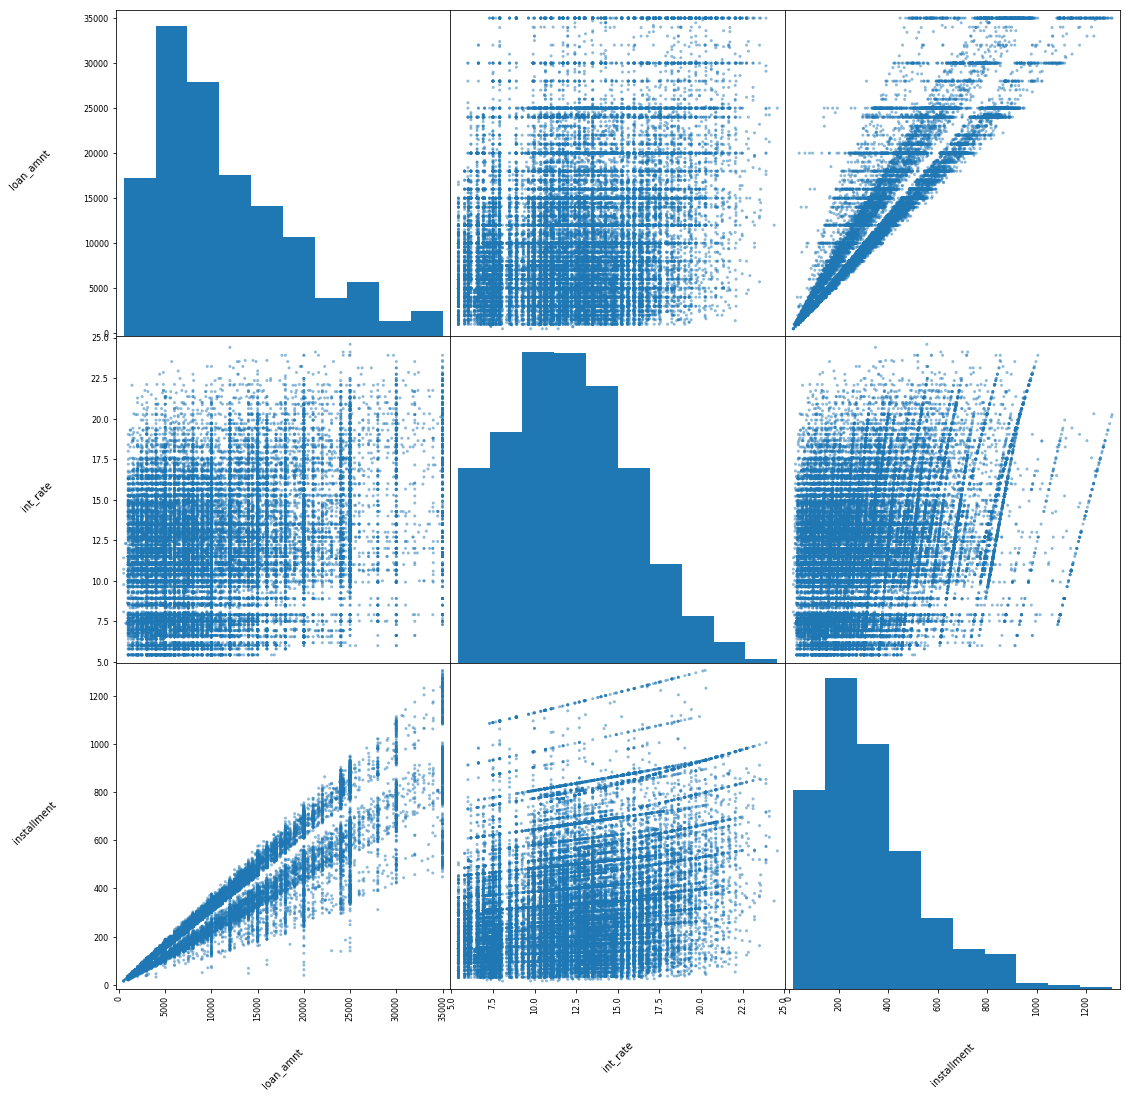

In [6]:
#Prepares a scatterplot of all the loan related numeric features
loanscatter = pd.plotting.scatter_matrix(features_raw[loan_numeric], alpha = 0.5,figsize = (18,18) , diagonal = 'hist')

#adjusts the labels on the plot so they don't overlap.
for x in range(len(loan_numeric)):
    for y in range(len(loan_numeric)):
        ax = loanscatter[x,y]
        ax.xaxis.label.set_rotation(45)
        ax.xaxis.labelpad = 25
        ax.yaxis.label.set_rotation(45)
        ax.yaxis.labelpad = 50


As might be expected there is a lot of correlation between installment and the other two features since these are the two compnents in determining the installment. 
There isn't any necessary reason to expect a correlation between the loan amount and the interest rate, and indeed the vizualization appears to have no relationship between the two.

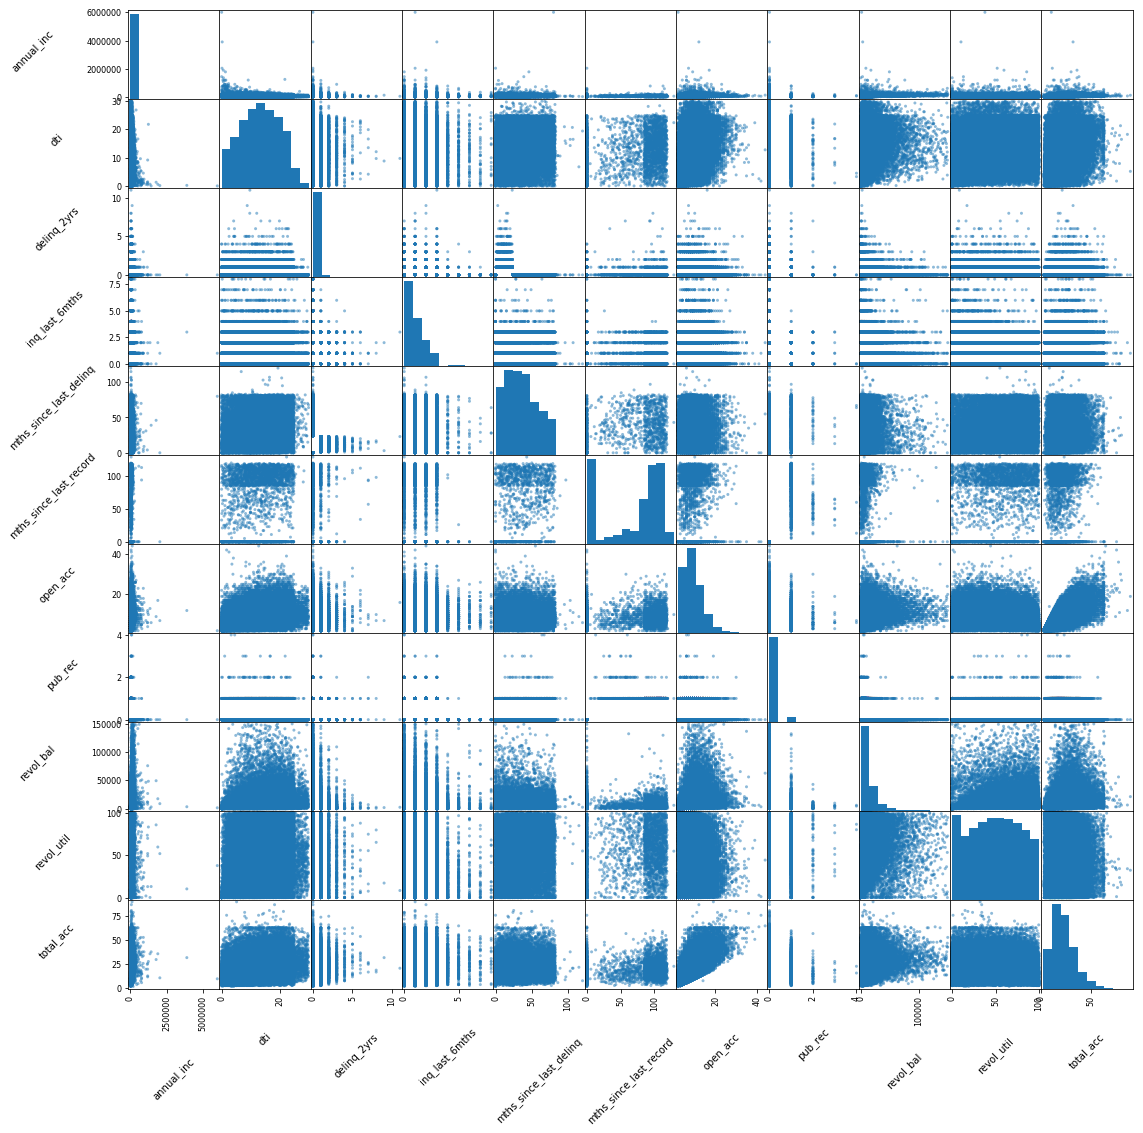

In [7]:
#Prepares a scatterplot of all the borrower related numeric features
borrowerscatter = pd.plotting.scatter_matrix(features_raw[borrower_numeric], alpha = 0.5,figsize = (18,18) , diagonal = 'hist')

#adjusts the labels on the plot so they don't overlap.
for x in range(len(borrower_numeric)):
    for y in range(len(borrower_numeric)):
        ax = borrowerscatter[x,y]
        ax.xaxis.label.set_rotation(45)
        ax.xaxis.labelpad = 25
        ax.yaxis.label.set_rotation(45)
        ax.yaxis.labelpad = 50


As expected, the borrower features bear less clear relationships. 
From the histograms, there are some features that appear skewed. Lets explore the skew value for each.

The graphs above indicate some features may suffer from a skewed distribution.
Let's look at the skew function for each borrower numberic freature.

In [8]:
#Review the numeric features skew to see if any may require transformation.
print(features_raw[borrower_numeric].skew())

annual_inc                30.941331
dti                       -0.027761
delinq_2yrs                5.019746
inq_last_6mths             1.389835
mths_since_last_delinq     0.306468
mths_since_last_record    -0.719310
open_acc                   1.003460
pub_rec                    4.557446
revol_bal                  3.189403
revol_util                -0.034931
total_acc                  0.827352
dtype: float64


In [9]:
#Import transformer
from sklearn.preprocessing import FunctionTransformer

#Before preprocessing operations copy the features_raw dataframe
transformed_features = pd.DataFrame(data = features_raw)

#list of features to be transformed
logtrans = ['annual_inc','revol_bal']

#Establish the log transformer
transformer = FunctionTransformer(np.log1p)

#apply the transform to the skewed features identified
transformed_features[logtrans] = transformer.transform(transformed_features[logtrans])


In [10]:
#Set up a list for features that would make for large one hot categories.
large_categories = []

print("The categorical values have uniquest values as follows:")

#Identify the features that would result in large one hot features
for c in categorical:
    uc = transformed_features[c].nunique()
    #Print feature and number of unique values.
    #Add to large_categories list if it owuld have over 100 one hot categories.
    if uc > 100:
        large_categories.append(c)
        print( "{}: {}  Remove from features.".format(str(c), uc))
    else:
        print( "{}: {}".format(str(c), uc))


The categorical values have uniquest values as follows:
term: 2
grade: 7
sub_grade: 35
emp_title: 28861  Remove from features.
emp_length: 12
home_ownership: 5
verification_status: 3
purpose: 14
zip_code: 823  Remove from features.
addr_state: 50
earliest_cr_line: 526  Remove from features.


There are three variables above, emp_title, zip_code and earliest_cr_line that have a large number of categories.
These variables will be set for learning purposes for two reasons; they will impart little information and thieir one hot encoding would result in large number of sparse features.

In [11]:
#Drop the large category features from the dataframe
transformed_features = transformed_features.drop(large_categories, axis = 1)

#Drop the large category features from the lists of features
for l in large_categories:
    categorical.remove(l)
    borrower_categorical.remove(l)

    


9999999999

Features that contain NaN entries will need to have preprocessing before learning algorithms can be applied.

In [12]:
#Identifies feetures with NaN entries that require precocessing.

#Establish list of features that will require imputer preprocssing.
contains_nan = []

# uhoh mths_since_last_major_derog
fc = transformed_features.columns.tolist()


#Identify features with NaN entries and add them to the feature collectore above
print("Features with at least one NaN entry:")
#for n in fc:
for n in numeric:
    nanc = transformed_features[n].isnull().values.sum()
    if nanc > 0:
        contains_nan.append(n)
        print("{} nan count: {}".format(n,nanc))

Features with at least one NaN entry:
mths_since_last_delinq nan count: 25727
mths_since_last_record nan count: 36995
revol_util nan count: 50


In [13]:
for nn in contains_nan: 
    print("{} len: {}".format(nn,len(transformed_features[nn])))

mths_since_last_delinq len: 39786
mths_since_last_record len: 39786
revol_util len: 39786


Clearly there are too many entries with an NaN entry to drop these observations, there would be hardly anything left in the dataset.

Instead will minimize the impact of these missing values by replacing them with the mode for those features.



In [14]:
#Import imputer to handle numeric NaN values
from sklearn.preprocessing import Imputer

#Set up imputer. 
#Using most Frequent because the features NaN are mostly zero entries and this will be the most neutral assumption
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)

#fit imputer to features with NaN values
imp.fit(transformed_features[contains_nan]) 

#Update features with NaN values with the imputer
transformed_features[contains_nan] = imp.transform(transformed_features[contains_nan])

#Prove the NaN values have been updated
for nn in contains_nan: 
    _ = transformed_features[nn].isnull().values.sum() 
    print("{} nan count: {}".format(nn,_))



mths_since_last_delinq nan count: 0
mths_since_last_record nan count: 0
revol_util nan count: 0


In [15]:
#Import the minmax scalar to put all features on a common size
from sklearn.preprocessing import MinMaxScaler

# Establishes the scaler
scaler = MinMaxScaler()
"""
#Sets up the raw data to be transformed in the next step
features_log_minmax_transform = pd.DataFrame(data = transformed_features )  #Sets up the raw data to be transformed in the next step
"""
# transforms the numeric features established earlier
transformed_features[numeric] = scaler.fit_transform(transformed_features[numeric])

display(transformed_features[numeric].describe())

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc
count,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000
mean,0.311054,0.344699,0.239662,0.366321,0.444074,0.013321,0.108631,0.105721,0.037929,0.173667,0.013786,0.730152,0.488456,0.228299
std,0.216364,0.194443,0.162019,0.076410,0.222684,0.044711,0.133759,0.179859,0.164789,0.104762,0.059413,0.159031,0.284001,0.129564
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.144928,0.199791,0.117402,0.316531,0.272758,0.000000,0.000000,0.000000,0.000000,0.095238,0.000000,0.689640,0.253253,0.125000
50%,0.275362,0.335942,0.205444,0.367978,0.447149,0.000000,0.125000,0.000000,0.000000,0.166667,0.000000,0.762809,0.493493,0.204545
75%,0.420290,0.478352,0.321900,0.413560,0.620207,0.000000,0.125000,0.175000,0.000000,0.238095,0.000000,0.817819,0.724725,0.306818
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Categorical features that have a large number of categories will be excluded for the purposes of learning because they will impart little information and thieir one hot encoding would result in large number of sparse features.

I've selected 100 unique values as the cutoff for a large number of categories.

Now to apply one hot encoding useing pandas get dummies


In [16]:
#one hot Encode the categorical features and assign to features_final 
features_final = pd.get_dummies(transformed_features, prefix = categorical )

#print the number of unencoded features
print("{} total features before one-hot encoding.".format(len(transformed_features.columns)))

#Check the number of features after one hot encoding.
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

22 total features before one-hot encoding.
142 total features after one-hot encoding.


In [17]:
#Import the train and test splitted from sklearn
from sklearn.model_selection import train_test_split

#split into train and test sets for features and target variable
X_train, X_test, y_train, y_test = train_test_split(features_final, paidoff , test_size=0.2, random_state=42)

Establish a benchmark model, as specified in the proposal I will use KNN as a benchmark


In [18]:
#Import metrics from sklearn for model evaluation
from sklearn.metrics import precision_score, classification_report

#Import the KNN classifier
from sklearn.neighbors import KNeighborsClassifier

#Establishes tags for the classification report
target_names = ['Default', 'Paidoff']

#Iterate through a few number of neighbors to help select the best model
for nn in range(1,6):
    #Set up the KNN classifier
    knc = KNeighborsClassifier(n_neighbors=nn)
    
    #Fit KNN to train set
    knc.fit(X_train, y_train)
    
    #predict on the test set
    y_pred = knc.predict(X_test)
    
    #Print out the classification report for the number of neighbors
    print("{} Neighbors".format(nn))
    print("-----------------------")
    print(classification_report(y_test, y_pred, target_names=target_names))

1 Neighbors
-----------------------
             precision    recall  f1-score   support

    Default       0.19      0.19      0.19      1107
    Paidoff       0.87      0.87      0.87      6851

avg / total       0.77      0.78      0.78      7958

2 Neighbors
-----------------------
             precision    recall  f1-score   support

    Default       0.19      0.35      0.25      1107
    Paidoff       0.88      0.76      0.82      6851

avg / total       0.78      0.71      0.74      7958

3 Neighbors
-----------------------
             precision    recall  f1-score   support

    Default       0.27      0.12      0.17      1107
    Paidoff       0.87      0.95      0.91      6851

avg / total       0.79      0.83      0.80      7958

4 Neighbors
-----------------------
             precision    recall  f1-score   support

    Default       0.25      0.20      0.22      1107
    Paidoff       0.87      0.90      0.89      6851

avg / total       0.79      0.80      0.79      79

The best paidoff precision score occured with 3 neighbors.
Below we will set this up as the benchmark classifier and see how well it performs on the training and test sets.

In [19]:
#The best classifier from above was with number of neighbors =3
#Set up the KNN as the benchmark
knc = KNeighborsClassifier(n_neighbors=3 )

#Fit benchmark to training set
knc.fit(X_train, y_train)

#Set up the training set benchmark predictions then print classification report
y_bm_train = knc.predict(X_train)
print("Classification Report for Training Set")
print(classification_report(y_train, y_bm_train, target_names=target_names))

#Set up the test set benchmark predictions then print classification report
y_bm_test = knc.predict(X_test)
print("Classification Report for Test Set")
print(classification_report(y_test, y_bm_test, target_names=target_names))


Classification Report for Training Set
             precision    recall  f1-score   support

    Default       0.70      0.32      0.44      4563
    Paidoff       0.90      0.98      0.93     27265

avg / total       0.87      0.88      0.86     31828

Classification Report for Test Set
             precision    recall  f1-score   support

    Default       0.27      0.12      0.17      1107
    Paidoff       0.87      0.95      0.91      6851

avg / total       0.79      0.83      0.80      7958



The small difference in performance between the trainng and test sets makes it unlikely there is overfitting.

Next I'll prepare some classifiers I beleive will do well and test their initial performance.

In [20]:
#Import support vector classifier
from sklearn.svm import SVC

#import encemble methods 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

#Import naive bayes classifier
from sklearn.naive_bayes import GaussianNB

#set up classifiers
nb = GaussianNB()
svc = SVC()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()

#collect classifiers into list
clfs = [nb, svc, rf, ada, gb]

#Iterate through the classifiers and print out their classification
for clf in clfs:
    #Fit the classifier to the training set
    clf.fit(X_train, y_train)
    
    #predict the targer for the test set
    y_pred = clf.predict(X_test)
    
    #prepare the claddifiation report
    print("Classification Report for Test Set for {}".format(clf.__class__.__name__))
    print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report for Test Set for GaussianNB
             precision    recall  f1-score   support

    Default       0.15      0.95      0.27      1107
    Paidoff       0.95      0.17      0.28      6851

avg / total       0.84      0.27      0.28      7958

Classification Report for Test Set for SVC
             precision    recall  f1-score   support

    Default       0.00      0.00      0.00      1107
    Paidoff       0.86      1.00      0.93      6851

avg / total       0.74      0.86      0.80      7958



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification Report for Test Set for RandomForestClassifier
             precision    recall  f1-score   support

    Default       0.27      0.06      0.10      1107
    Paidoff       0.86      0.97      0.92      6851

avg / total       0.78      0.85      0.80      7958

Classification Report for Test Set for AdaBoostClassifier
             precision    recall  f1-score   support

    Default       0.44      0.02      0.05      1107
    Paidoff       0.86      1.00      0.92      6851

avg / total       0.80      0.86      0.80      7958

Classification Report for Test Set for GradientBoostingClassifier
             precision    recall  f1-score   support

    Default       0.42      0.01      0.02      1107
    Paidoff       0.86      1.00      0.92      6851

avg / total       0.80      0.86      0.80      7958



Clearly GaussianNB is outperforming all other classifiers on the paidoff precision metric.


In [21]:
#Fit the classifier to the training set
nb.fit(X_train, y_train)

#predict the target for the test set
y_nb_pred = nb.predict(X_test)

#confirm classification report is the same as above
print(classification_report(y_test, y_nb_pred, target_names=target_names))

             precision    recall  f1-score   support

    Default       0.15      0.95      0.27      1107
    Paidoff       0.95      0.17      0.28      6851

avg / total       0.84      0.27      0.28      7958



In [22]:
# Build comparison of the performance
model_comp = X_test.copy()
model_comp['loan_status'] = y_test
model_comp['nb_pred'] = y_nb_pred


Lets look at the performance of the model by grade

In [36]:
#Setup grades and subgrades
oh_grades = ['grade_A','grade_B','grade_C','grade_D','grade_E','grade_F','grade_G']
oh_subgrades = ['sub_grade_A1','sub_grade_A2','sub_grade_A3','sub_grade_A4', 'sub_grade_A5' ,'sub_grade_B1' ,'sub_grade_B2' ,'sub_grade_B3','sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2' ,'sub_grade_C3' ,'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1' ,'sub_grade_D2' ,'sub_grade_D3' ,'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3' ,'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3' ,'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3','sub_grade_G4', 'sub_grade_G5']

#setup dictionary for freeform vizualization 
nbplt = {}


#Examine performance by grade
for ohg in oh_subgrades:
    ga = model_comp[model_comp[ohg] == 1]
    tp = ga[ga.nb_pred == True]['loan_status'].sum()
    ttl = ga[ga.nb_pred == True]['loan_status'].count()
    prc = float(tp/ttl)
    
    if ttl > 0:
        nbplt[ohg] = prc
        
    
    print("{} precision: {}  Loan count: {}".format(ohg,prc,ttl))

sub_grade_A1 precision: 0.979757085020243  Loan count: 247
sub_grade_A2 precision: 0.95  Loan count: 300
sub_grade_A3 precision: 0.9498432601880877  Loan count: 319
sub_grade_A4 precision: 0.9433962264150944  Loan count: 159
sub_grade_A5 precision: 0.9591836734693877  Loan count: 49
sub_grade_B1 precision: 1.0  Loan count: 12
sub_grade_B2 precision: 1.0  Loan count: 11
sub_grade_B3 precision: 0.8  Loan count: 15
sub_grade_B4 precision: 0.8  Loan count: 10
sub_grade_B5 precision: 1.0  Loan count: 12
sub_grade_C1 precision: 0.9  Loan count: 10
sub_grade_C2 precision: 1.0  Loan count: 7
sub_grade_C3 precision: 0.6666666666666666  Loan count: 3
sub_grade_C4 precision: 0.8  Loan count: 5
sub_grade_C5 precision: 0.8571428571428571  Loan count: 7
sub_grade_D1 precision: 1.0  Loan count: 3
sub_grade_D2 precision: 0.8333333333333334  Loan count: 6
sub_grade_D3 precision: 1.0  Loan count: 2
sub_grade_D4 precision: 0.5  Loan count: 4
sub_grade_D5 precision: 1.0  Loan count: 3
sub_grade_E1 precisi

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


Stepping beyond the scope of my capstone proposal, I'll construct a multilayer classifier to see if it performs better than the nieve bayes classifier above.

In [24]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout


model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=100,
          batch_size=128)
score = model.evaluate(X_test, y_test, batch_size=128)

Using TensorFlow backend.


Epoch 1/100
31828/31828 [==============================] - 1s 25us/step - loss: 0.3919 - acc: 0.8543
Epoch 2/100
31828/31828 [==============================] - 1s 18us/step - loss: 0.3825 - acc: 0.8566
Epoch 3/100
31828/31828 [==============================] - 1s 19us/step - loss: 0.3791 - acc: 0.8567
Epoch 4/100
31828/31828 [==============================] - 1s 21us/step - loss: 0.3747 - acc: 0.8573
Epoch 5/100
31828/31828 [==============================] - 1s 20us/step - loss: 0.3700 - acc: 0.8576
Epoch 6/100
31828/31828 [==============================] - 1s 18us/step - loss: 0.3635 - acc: 0.8602
Epoch 7/100
31828/31828 [==============================] - 1s 18us/step - loss: 0.3565 - acc: 0.8610
Epoch 8/100
31828/31828 [==============================] - 1s 18us/step - loss: 0.3485 - acc: 0.8649
Epoch 9/100
31828/31828 [==============================] - 1s 18us/step - loss: 0.3394 - acc: 0.8670
Epoch 10/100
31828/31828 [==============================] - 1s 18us/step - loss: 0.3292 - a

31828/31828 [==============================] - 1s 18us/step - loss: 0.0489 - acc: 0.9827
Epoch 82/100
31828/31828 [==============================] - 1s 18us/step - loss: 0.0446 - acc: 0.9839
Epoch 83/100
31828/31828 [==============================] - 1s 18us/step - loss: 0.0452 - acc: 0.9841
Epoch 84/100
31828/31828 [==============================] - 1s 18us/step - loss: 0.0474 - acc: 0.9839
Epoch 85/100
31828/31828 [==============================] - 1s 25us/step - loss: 0.0419 - acc: 0.9851
Epoch 86/100
31828/31828 [==============================] - 1s 24us/step - loss: 0.0434 - acc: 0.9848
Epoch 87/100
31828/31828 [==============================] - 1s 21us/step - loss: 0.0387 - acc: 0.9855
Epoch 88/100
31828/31828 [==============================] - 1s 19us/step - loss: 0.0409 - acc: 0.9852
Epoch 89/100
31828/31828 [==============================] - 1s 18us/step - loss: 0.0432 - acc: 0.9853
Epoch 90/100
31828/31828 [==============================] - 1s 18us/step - loss: 0.0430 - acc: 

In [30]:
#Setup the predictions from the neural network
nn_pred = model.predict(X_test)

#Conver the nn_pred numerical values to boolean variables.
cutoff = 0.5
y_nn_pred = pd.Series( bool(y > cutoff) for y in y_pred)

train_pred = model.predict(X_train)
y_train_pred = pd.Series( bool(y > cutoff) for y in train_pred)

#add the Neural Network predicitons to the model_comp dataframe
model_comp['nn_pred'] = y_nn_pred

#Examine the classification report forthe training set
print("Classification Report for Test Set")
print(classification_report(y_train, y_train_pred , target_names=target_names))

#Examine the classification report for comparison to the naieve bayes model
print("Classification Report for Test Set")
print(classification_report(y_test, y_nn_pred, target_names=target_names))


Classification Report for Test Set
             precision    recall  f1-score   support

    Default       0.97      0.99      0.98      4563
    Paidoff       1.00      1.00      1.00     27265

avg / total       0.99      0.99      0.99     31828

Classification Report for Test Set
             precision    recall  f1-score   support

    Default       0.42      0.01      0.02      1107
    Paidoff       0.86      1.00      0.92      6851

avg / total       0.80      0.86      0.80      7958



Despite the accuracy metric being 98.99%, the performance of the paidoff precision metric is well below the naieve bayes performance on this metric.

Perhaps a custom loss function that more heavily penalizes fales negativies would properly incetivies the network.
I'll reserve this problem for a future project.

In [26]:

print("precision scores for the Neural Network model:")
for ohg in oh_grades:
    ga = model_comp[model_comp[ohg] == 1]
    tp = ga[ga.nn_pred == True]['loan_status'].sum()
    ttl = ga[ga.nn_pred == True]['loan_status'].count()
    prc = float(tp/ttl)
    
    print("{} precision: {}  Loan count: {}".format(ohg,prc,ttl))

precision scores for the Neural Network model:
grade_A precision: 0.933184855233853  Loan count: 449
grade_B precision: 0.8732943469785575  Loan count: 513
grade_C precision: 0.785234899328859  Loan count: 298
grade_D precision: 0.7619047619047619  Loan count: 189
grade_E precision: 0.7421875  Loan count: 128
grade_F precision: 0.5238095238095238  Loan count: 42
grade_G precision: 0.6428571428571429  Loan count: 14


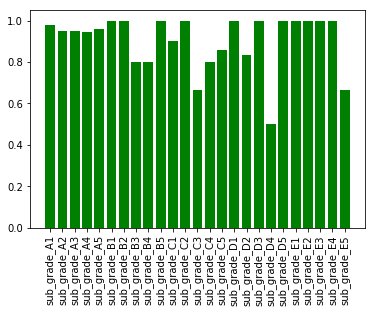

In [42]:
#Prepare Freeform visualization

#Plot the paidoff precision by subgrade from the directory constructed earlier
plt.bar(nbplt.keys(), nbplt.values(), color='g')
plt.xticks(rotation=90)
plt.show()